# Invasive Devices
Feature Engineering: Invasive Devices



Load libraries and setup environment

In [84]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from sklearn.manifold import TSNE

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

MIMIC BigQuery access

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# MIMIC project ID
project_id = "ml-health-395010"

MIMIC IV setup (MIMIC IV version 2.2)

In [3]:
# CODE TAKEN FROM TUTORIAL 3
# accessed at: 14-08-2023

# Set up environment variables
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## HAI Positives
Load HAI positives dataset

In [14]:
HAI_POS_PATH = "/content/drive/MyDrive/ML Health/proposal/HAI Positive Patients.csv"

hai_pos_df = pd.read_csv(HAI_POS_PATH)
hai_pos_df

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580.0,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361.0,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,10207354,24602624,NaN,T80219A,Unspecified infection due to central venous ca...,CLABSI
3,11624559,29387474,NaN,T80218A,Other infection due to central venous catheter...,CLABSI
4,11864591,27843066,NaN,T83510A,Infection and inflammatory reaction due to cys...,CAUTI
...,...,...,...,...,...,...
5564,13766350,26137394,30935196.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5565,12200502,29234722,32185728.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5566,12200502,29234722,39773284.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5567,11708854,20452061,NaN,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI


remove null stay_id

In [20]:
hai_pos_df = hai_pos_df[hai_pos_df['stay_id'].notna()]
hai_pos_df = hai_pos_df.reset_index(drop=True)
hai_pos_df["stay_id"] = pd.to_numeric(hai_pos_df["stay_id"], downcast='integer')
hai_pos_df

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,12297168,28749499,33007017,T80218A,Other infection due to central venous catheter...,CLABSI
3,12490029,26495589,33759728,T83510A,Infection and inflammatory reaction due to cys...,CAUTI
4,14471034,24151113,39723144,T80218A,Other infection due to central venous catheter...,CLABSI
...,...,...,...,...,...,...
3410,15616719,26378988,32812963,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3411,13766350,26137394,36527141,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3412,13766350,26137394,30935196,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3413,12200502,29234722,32185728,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI


types of HAI

In [21]:
hai_pos_df["HAI_Type"].unique()

array(['CLABSI', 'CAUTI', 'VAP'], dtype=object)

HAI as label

In [61]:
hai_pos_df = hai_pos_df[["stay_id", "HAI_Type"]]
hai_pos_df

,stay_id,HAI_Type
0,32359580,CLABSI
1,39785361,CLABSI
2,33007017,CLABSI
3,33759728,CAUTI
4,39723144,CLABSI
...,...,...
3410,32812963,CAUTI
3411,36527141,CAUTI
3412,30935196,CAUTI
3413,32185728,CAUTI


## Central Line-Associated Bloodstream Infection (CLABSI)

In [24]:
clabsi = """
SELECT
    mv.stay_id,
    -- mv.itemid,
    CASE
        WHEN di.label IN ('Arterial Line', 'A-Line') THEN 'Arterial'
        WHEN di.label IN ('CCO PA Line', 'CCO PAC') THEN 'Continuous Cardiac Output PA'
        WHEN di.label IN ('Dialysis Catheter', 'Dialysis Line') THEN 'Dialysis'
        WHEN di.label IN ('Hickman', 'Tunneled (Hickman) Line') THEN 'Hickman'
        WHEN di.label IN ('IABP', 'IABP line') THEN 'IABP'
        WHEN di.label IN ('Multi Lumen', 'Multi-lumen') THEN 'Multi Lumen'
        WHEN di.label IN ('PA Catheter', 'PA line') THEN 'PA'
        WHEN di.label IN ('PICC Line', 'PICC line') THEN 'PICC'
        WHEN di.label IN ('Pre-Sep Catheter', 'Presep Catheter') THEN 'Pre-Sep'
        WHEN di.label IN ('Trauma Line', 'Trauma line') THEN 'Trauma'
        WHEN di.label IN ('Triple Introducer', 'TripleIntroducer') THEN 'Triple Introducer'
        WHEN di.label IN ('Portacath', 'Indwelling Port (PortaCath)') THEN 'Portacath'
        ELSE di.label
    END AS type,
    mv.starttime,
    mv.endtime,
    CASE
        WHEN mv.location IN ('Left Antecub', 'Left Antecube') THEN 'Left Antecube'
        WHEN mv.location IN ('Left Axilla', 'Left Axilla.') THEN 'Left Axilla'
        WHEN mv.location IN ('Left Brachial', 'Left Brachial.') THEN 'Left Brachial'
        WHEN mv.location IN ('Left Femoral', 'Left Femoral.') THEN 'Left Femoral'
        WHEN mv.location IN ('Right Antecub', 'Right Antecube') THEN 'Right Antecube'
        WHEN mv.location IN ('Right Axilla', 'Right Axilla.') THEN 'Right Axilla'
        WHEN mv.location IN ('Right Brachial', 'Right Brachial.') THEN 'Right Brachial'
        WHEN mv.location IN ('Right Femoral', 'Right Femoral.') THEN 'Right Femoral'
        ELSE mv.location
    END AS value -- location
FROM `physionet-data.mimiciv_icu.procedureevents` mv
INNER JOIN `physionet-data.mimiciv_icu.d_items` di
ON mv.itemid = di.itemid
WHERE mv.itemid IN
(
    227719 -- AVA Line
    , 225752 -- Arterial Line
    , 224269 -- CCO PAC
    , 224267 -- Cordis/Introducer
    , 224270 -- Dialysis Catheter
    , 224272 -- IABP line
    , 226124 -- ICP Catheter
    , 228169 -- Impella Line
    , 225202 -- Indwelling Port (PortaCath)
    , 228286 -- Intraosseous Device
    , 225204 -- Midline
    , 224263 -- Multi Lumen
    , 224560 -- PA Catheter
    , 224264 -- PICC Line
    , 225203 -- Pheresis Catheter
    , 224273 -- Presep Catheter
    , 225789 -- Sheath
    , 225761 -- Sheath Insertion
    , 228201 -- Tandem Heart Access Line
    , 228202 -- Tandem Heart Return Line
    , 224268 -- Trauma line
    , 225199 -- Triple Introducer
    , 225315 -- Tunneled (Hickman) Line
    , 225205 -- RIC
)
-- AND mv.location is not null   --- !!!!! COMMENT THIS LINE WHEN EXTRATING FEATURE
-- LIMIT 1000
;
"""

In [49]:
clabsi_df_ori = run_query(clabsi)
clabsi_df_ori

,stay_id,type,starttime,endtime,value
0,37510196,Multi Lumen,2131-01-14 19:00:00,2131-01-20 08:27:00,None
1,30676350,Multi Lumen,2175-10-08 18:42:00,2175-10-09 11:59:00,None
2,34100191,Multi Lumen,2196-02-25 15:16:00,2196-02-29 15:58:00,None
3,39699336,Multi Lumen,2144-06-07 12:54:00,2144-06-18 23:24:00,None
4,30213599,Multi Lumen,2159-02-22 18:00:00,2159-02-25 22:03:00,None
...,...,...,...,...,...
93373,35496907,RIC,2138-02-18 09:22:00,2138-02-19 15:50:00,Right Accessory Basilic
93374,32875883,RIC,2186-05-02 04:00:00,2186-05-04 15:01:00,Right Accessory Cephalic
93375,32678336,RIC,2149-03-29 01:00:00,2149-03-29 15:57:00,Right Accessory Cephalic
93376,38944279,RIC,2140-10-27 22:15:00,2140-10-29 12:19:00,Right Accessory Cephalic


Note:   
- value is location

count missing value

In [116]:
clabsi_df = clabsi_df_ori.copy()
clabsi_df[clabsi_df['value'].isna()].shape[0]

37810

create feature

In [117]:
# calc duration
clabsi_df["duration"] = (clabsi_df["endtime"] - clabsi_df["starttime"]).dt.total_seconds()
clabsi_df = clabsi_df.drop('endtime',axis = 1)
clabsi_df = clabsi_df.drop('starttime',axis = 1)

# one-hot-encoding
for col in ["type", "value"]:
  one_hot = pd.get_dummies(clabsi_df[col])
  one_hot.columns = [col + "-" + c.lower().replace(" ", "_") for c in list(one_hot.columns)]
  clabsi_df = clabsi_df.drop(col,axis = 1)
  clabsi_df = clabsi_df.join(one_hot)

# clabsi_df
clabsi_df

,stay_id,duration,type-ava,type-arterial,type-continuous_cardiac_output_pa,type-cordis/introducer,type-dialysis,type-hickman,type-iabp,type-icp_catheter,...,value-right_foot,value-right_humeral_head,value-right_ij,value-right_metacarpal,value-right_proximal_tibia,value-right_radial,value-right_side_head,value-right_subclavian,value-right_ulnar,value-right_upper_arm
0,37510196,480420.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30676350,62220.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34100191,348120.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39699336,988200.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30213599,273780.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93373,35496907,109680.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93374,32875883,212460.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93375,32678336,53820.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93376,38944279,137040.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


join with label

In [118]:
clabsi_df = clabsi_df.join(hai_pos_df.set_index("stay_id"), on='stay_id')
clabsi_df["label"] = clabsi_df["HAI_Type"].apply(lambda x: 1 if x == "CAUTI" else 0)

clabsi_df = clabsi_df.drop('stay_id',axis = 1)
clabsi_df = clabsi_df.drop('HAI_Type',axis = 1)

print(clabsi_df["label"].sum())

clabsi_df

753


,duration,type-ava,type-arterial,type-continuous_cardiac_output_pa,type-cordis/introducer,type-dialysis,type-hickman,type-iabp,type-icp_catheter,type-impella_line,...,value-right_humeral_head,value-right_ij,value-right_metacarpal,value-right_proximal_tibia,value-right_radial,value-right_side_head,value-right_subclavian,value-right_ulnar,value-right_upper_arm,label
0,480420.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,62220.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,348120.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,988200.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,273780.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93373,109680.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93374,212460.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93375,53820.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93376,137040.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


feature importance

[Text(0.5, 1.0, 'correlation between feature')]

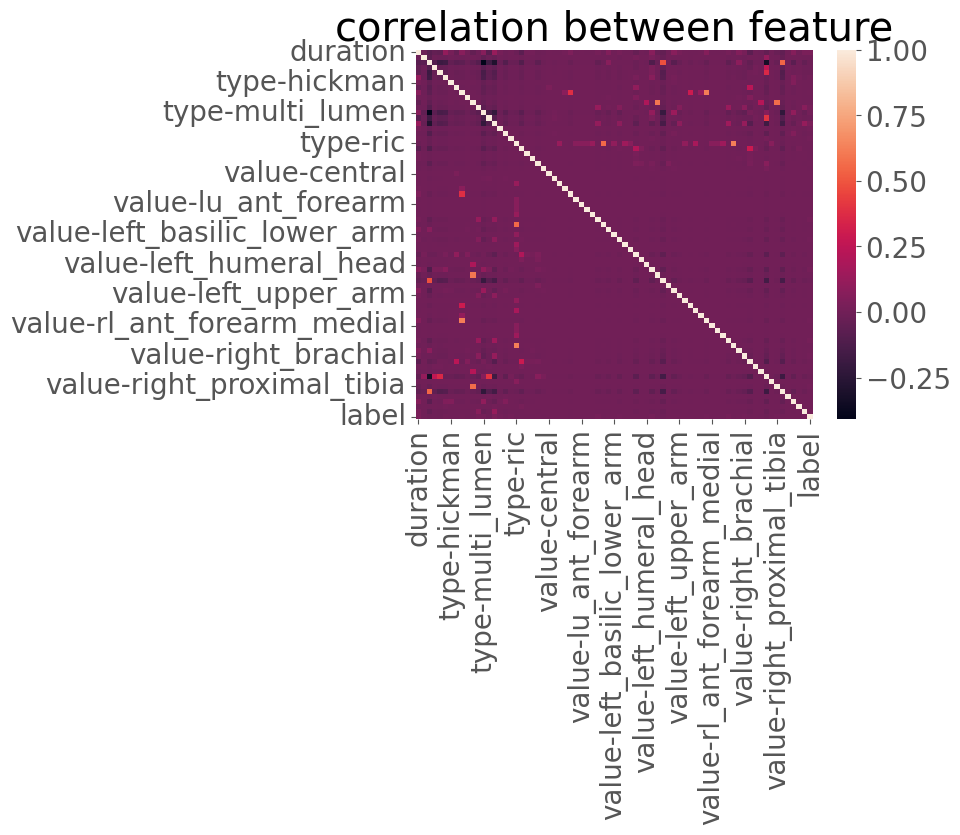

In [119]:
# correlation heatmap
sns.heatmap(clabsi_df.corr(), annot=False).set(title="correlation between feature")

In [120]:
# rank correlation to label
clabsi_df.corr().loc["label", :].sort_values(ascending=False)

label                                1.000000
type-picc                            0.036648
duration                             0.031551
type-midline                         0.013612
value-left_antecube                  0.012699
                                       ...   
type-continuous_cardiac_output_pa   -0.010948
type-pa                             -0.012325
value-right_ij                      -0.015414
type-cordis/introducer              -0.015947
type-arterial                       -0.016040
Name: label, Length: 73, dtype: float64

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1506 samples in 0.001s...
[t-SNE] Computed neighbors for 1506 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1506
[t-SNE] Computed conditional probabilities for sample 1506 / 1506
[t-SNE] Mean sigma: 1.256220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.908264
[t-SNE] KL divergence after 1000 iterations: 0.430171


[Text(0.5, 1.0, 'CLABSI T-SNE projection')]

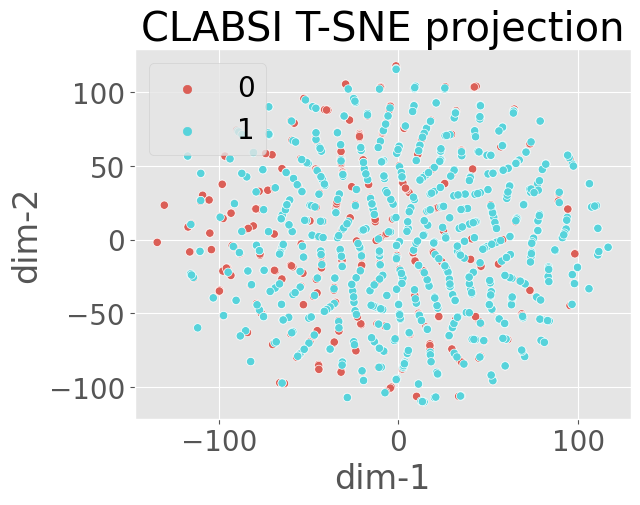

In [121]:
# embedding visualization
sampled = clabsi_df.groupby('label', group_keys=False).apply(lambda x: x.sample(clabsi_df["label"].sum()))
X = sampled.drop('label',axis = 1)
y = sampled["label"]

tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=2, n_iter=1000)
emb = tsne.fit_transform(X)

df = pd.DataFrame({
    "y": y,
    "dim-1": emb[:, 0],
    "dim-2": emb[:, 1]
})

sns.scatterplot(
    x="dim-1",
    y="dim-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df
).set(title="CLABSI T-SNE projection")

## Ventilator-Associated Pneumonia (VAP)

In [94]:
vap = """
SELECT
    tm.stay_id,
    CASE
        WHEN ventilator_mode is not null THEN ventilator_mode
        WHEN ventilator_mode_hamilton is not null THEN ventilator_mode_hamilton
        ELSE null
    END as type,
    MIN(tm.charttime) as starttime,
    MAX(tm.charttime) as endtime,
    o2_delivery_device_1 as value
FROM
  (
    SELECT stay_id, charttime
    FROM `physionet-data.mimiciv_derived.ventilator_setting`
    UNION DISTINCT
    SELECT stay_id, charttime
    FROM `physionet-data.mimiciv_derived.oxygen_delivery`
  ) as tm
  LEFT JOIN `physionet-data.mimiciv_derived.ventilator_setting` vs
      ON tm.stay_id = vs.stay_id
      AND tm.charttime = vs.charttime
  LEFT JOIN `physionet-data.mimiciv_derived.oxygen_delivery` od
      ON tm.stay_id = od.stay_id
      AND tm.charttime = od.charttime
WHERE
    o2_delivery_device_1 IN
    (
        'Endotracheal tube'
    )
    OR ventilator_mode IN
    (
        '(S) CMV',
        'APRV',
        'APRV/Biphasic+ApnPress',
        'APRV/Biphasic+ApnVol',
        'APV (cmv)',
        'Ambient',
        'Apnea Ventilation',
        'CMV',
        'CMV/ASSIST',
        'CMV/ASSIST/AutoFlow',
        'CMV/AutoFlow',
        'CPAP/PPS',
        'CPAP/PSV+Apn TCPL',
        'CPAP/PSV+ApnPres',
        'CPAP/PSV+ApnVol',
        'MMV',
        'MMV/AutoFlow',
        'MMV/PSV',
        'MMV/PSV/AutoFlow',
        'P-CMV',
        'PCV+',
        'PCV+/PSV',
        'PCV+Assist',
        'PRES/AC',
        'PRVC/AC',
        'PRVC/SIMV',
        'PSV/SBT',
        'SIMV',
        'SIMV/AutoFlow',
        'SIMV/PRES',
        'SIMV/PSV',
        'SIMV/PSV/AutoFlow',
        'SIMV/VOL',
        'SYNCHRON MASTER',
        'SYNCHRON SLAVE',
        'VOL/AC'
    )
    OR ventilator_mode_hamilton IN
    (
        'APRV',
        'APV (cmv)',
        'Ambient',
        '(S) CMV',
        'P-CMV',
        'SIMV',
        'APV (simv)',
        'P-SIMV',
        'VS',
        'ASV'
    )
GROUP BY
    tm.stay_id, type, o2_delivery_device_1
HAVING
    -- type is not null
    -- AND o2_delivery_device_1 is not null
    MIN(tm.charttime) != MAX(tm.charttime)
-- LIMIT 1000
;
"""

In [95]:
vap_df_ori = run_query(vap)
vap_df_ori

,stay_id,type,starttime,endtime,value
0,36283909,CMV/ASSIST/AutoFlow,2142-10-06 18:00:00,2142-10-06 19:00:00,None
1,30532359,None,2175-04-11 22:59:00,2175-04-12 01:10:00,Endotracheal tube
2,38980177,Ambient,2145-04-15 08:00:00,2145-04-15 18:00:00,Trach mask
3,31817310,None,2142-09-06 16:50:00,2142-09-06 17:00:00,Endotracheal tube
4,36796263,None,2126-12-22 23:39:00,2126-12-23 02:30:00,Endotracheal tube
...,...,...,...,...,...
31164,37231956,CMV/ASSIST/AutoFlow,2117-11-17 02:28:00,2117-11-17 04:00:00,None
31165,30417144,CMV/ASSIST/AutoFlow,2167-11-26 20:00:00,2167-11-26 23:00:00,None
31166,35035748,CMV/ASSIST/AutoFlow,2139-03-15 08:00:00,2139-03-15 12:00:00,None
31167,36810012,CMV/ASSIST/AutoFlow,2127-03-29 13:34:00,2127-03-29 15:00:00,None


Note:
- type is the ventilator mode
- value will be the oxygen delivery device

count missing value

In [122]:
vap_df = vap_df_ori.copy()
vap_df[vap_df['value'].isna()].shape[0]

31019

create feature

In [123]:
# calc duration
vap_df["duration"] = (vap_df["endtime"] - vap_df["starttime"]).dt.total_seconds()
vap_df = vap_df.drop('endtime',axis = 1)
vap_df = vap_df.drop('starttime',axis = 1)

# one-hot-encoding
for col in ["type", "value"]:
  one_hot = pd.get_dummies(vap_df[col])
  one_hot.columns = [col + "-" + c.lower().replace(" ", "_") for c in list(one_hot.columns)]
  vap_df = vap_df.drop(col,axis = 1)
  vap_df = vap_df.join(one_hot)

# vap_df
vap_df

,stay_id,duration,type-(s)_cmv,type-aprv,type-aprv/biphasic+apnpress,type-aprv/biphasic+apnvol,type-apv_(cmv),type-apv_(simv),type-asv,type-ambient,...,type-vol/ac,type-vs,value-aerosol-cool,value-endotracheal_tube,value-high_flow_nasal_cannula,value-high_flow_neb,value-nasal_cannula,value-t-piece,value-trach_mask_,value-tracheostomy_tube
0,36283909,3600.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30532359,7860.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,38980177,36000.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,31817310,600.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,36796263,10260.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31164,37231956,5520.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31165,30417144,10800.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31166,35035748,14400.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31167,36810012,5160.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


join with label

In [124]:
vap_df = vap_df.join(hai_pos_df.set_index("stay_id"), on='stay_id')
vap_df["label"] = vap_df["HAI_Type"].apply(lambda x: 1 if x == "VAP" else 0)

vap_df = vap_df.drop('stay_id',axis = 1)
vap_df = vap_df.drop('HAI_Type',axis = 1)

print(vap_df["label"].sum())

vap_df

3703


,duration,type-(s)_cmv,type-aprv,type-aprv/biphasic+apnpress,type-aprv/biphasic+apnvol,type-apv_(cmv),type-apv_(simv),type-asv,type-ambient,type-apnea_ventilation,...,type-vs,value-aerosol-cool,value-endotracheal_tube,value-high_flow_nasal_cannula,value-high_flow_neb,value-nasal_cannula,value-t-piece,value-trach_mask_,value-tracheostomy_tube,label
0,3600.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7860.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,36000.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,600.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,10260.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31164,5520.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31165,10800.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31166,14400.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31167,5160.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


feature importance

[Text(0.5, 1.0, 'correlation between feature')]

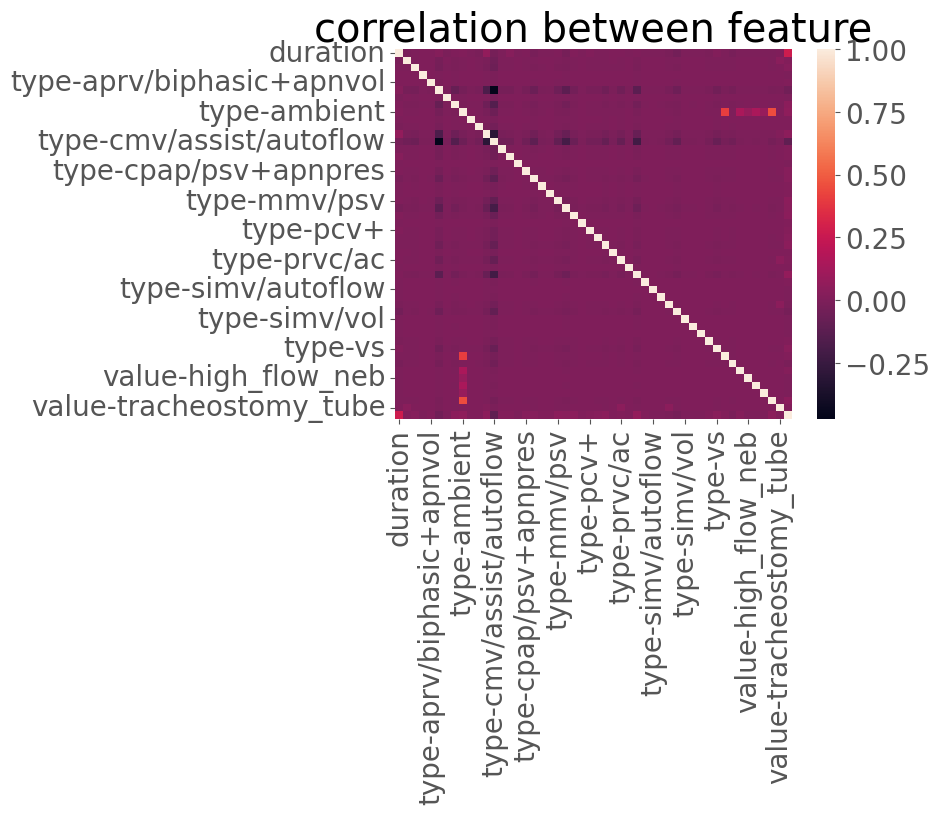

In [125]:
# correlation heatmap
sns.heatmap(vap_df.corr(), annot=False).set(title="correlation between feature")

In [126]:
# rank correlation to label
vap_df.corr().loc["label", :].sort_values(ascending=False)

label                            1.000000
duration                         0.271959
type-psv/sbt                     0.067855
type-ambient                     0.050500
type-cmv/assist                  0.047921
type-asv                         0.044619
type-mmv/psv                     0.044450
type-p-cmv                       0.043681
value-trach_mask_                0.042011
type-pcv+assist                  0.041107
type-vs                          0.038653
type-mmv/psv/autoflow            0.034230
type-pcv+/psv                    0.029019
type-cpap/psv+apnpres            0.027328
type-aprv                        0.023426
type-cpap/psv+apnvol             0.023166
type-pcv+                        0.019116
value-high_flow_nasal_cannula    0.016633
value-aerosol-cool               0.014905
type-cmv/autoflow                0.012915
value-tracheostomy_tube          0.012727
type-cpap/pps                    0.011959
type-(s)_cmv                     0.010796
type-mmv                         0

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7406 samples in 0.002s...
[t-SNE] Computed neighbors for 7406 samples in 0.825s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7406
[t-SNE] Computed conditional probabilities for sample 2000 / 7406
[t-SNE] Computed conditional probabilities for sample 3000 / 7406
[t-SNE] Computed conditional probabilities for sample 4000 / 7406
[t-SNE] Computed conditional probabilities for sample 5000 / 7406
[t-SNE] Computed conditional probabilities for sample 6000 / 7406
[t-SNE] Computed conditional probabilities for sample 7000 / 7406
[t-SNE] Computed conditional probabilities for sample 7406 / 7406
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.148117
[t-SNE] KL divergence after 1000 iterations: 0.621570


[Text(0.5, 1.0, 'VAP T-SNE projection')]

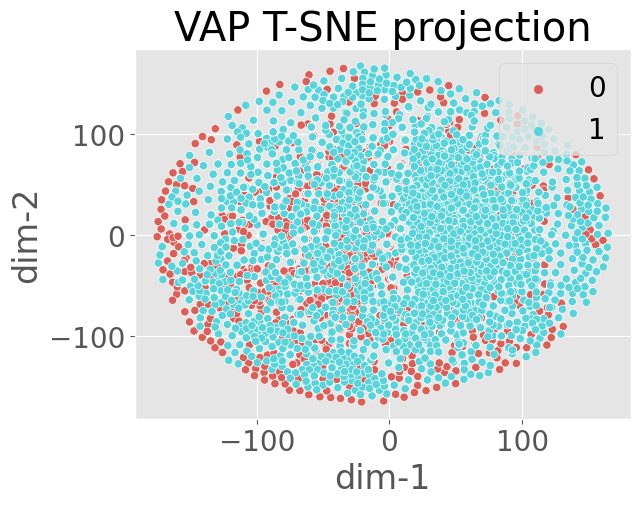

In [127]:
# embedding visualization
sampled = vap_df.groupby('label', group_keys=False).apply(lambda x: x.sample(vap_df["label"].sum()))
X = sampled.drop('label',axis = 1)
y = sampled["label"]

tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=2, n_iter=1000)
emb = tsne.fit_transform(X)

df = pd.DataFrame({
    "y": y,
    "dim-1": emb[:, 0],
    "dim-2": emb[:, 1]
})

sns.scatterplot(
    x="dim-1",
    y="dim-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df
).set(title="VAP T-SNE projection")

## Catheter-Associated Urinary Tract Infection (CAUTI)

In [103]:
cauti = """
-- mimiciv_derive.urine_output.sql
select
  stay_id,
  CASE itemid
    WHEN 226559 THEN 'Foley'
    WHEN 226561 THEN 'Condom Cath'
    WHEN 226584 THEN 'Ileoconduit'
    WHEN 226563 THEN 'Suprapubic'
    WHEN 226564 THEN 'R Nephrostomy'
    WHEN 226565 THEN 'L Nephrostomy'
    WHEN 226567 THEN 'Straight Cath'
    WHEN 226557 THEN 'R Ureteral Stent'
    WHEN 226558 THEN 'L Ureteral Stent'
    ELSE ''
    END as type,
  MIN(charttime) as starttime,
  MAX(charttime) as endtime,
  sum(urineoutput) as value
from
(
    select
    -- patient identifiers
    oe.stay_id,
    oe.itemid,
    oe.charttime,
    -- volumes associated with urine output ITEMIDs
    -- note we consider input of GU irrigant as a negative volume
    -- GU irrigant volume in usually has a corresponding volume out
    -- so the net is often 0, despite large irrigant volumes
    case
        when oe.itemid = 227488 and oe.value > 0 then -1*oe.value
        else oe.value
    end as urineoutput
    from `physionet-data.mimiciv_icu.outputevents` oe
    where itemid in
    (
    226559, -- Foley
    -- 226560, -- Void
    226561, -- Condom Cath
    226584, -- Ileoconduit
    226563, -- Suprapubic
    226564, -- R Nephrostomy
    226565, -- L Nephrostomy
    226567, -- Straight Cath
    226557, -- R Ureteral Stent
    226558 -- L Ureteral Stent
    -- 227488, -- GU Irrigant Volume In
    -- 227489  -- GU Irrigant/Urine Volume Out
    )
) uo
group by stay_id, itemid
HAVING
  MIN(charttime) != MAX(charttime)
-- LIMIT 1000
;
"""

In [104]:
cauti_df_ori = run_query(cauti)
cauti_df_ori

,stay_id,type,starttime,endtime,value
0,39765666,Foley,2189-06-27 09:08:00,2189-06-27 17:00:00,3900.0
1,31205490,Foley,2110-04-11 17:00:00,2110-04-12 20:00:00,2665.0
2,37510196,Foley,2131-01-11 08:00:00,2131-01-20 00:00:00,11708.0
3,39060235,Foley,2160-05-18 14:30:00,2160-05-19 16:00:00,2435.0
4,32358465,Foley,2131-03-10 00:00:00,2131-03-10 12:00:00,310.0
...,...,...,...,...,...
56845,37364566,Foley,2162-08-16 07:00:00,2162-08-23 04:00:00,3727.0
56846,32336619,Foley,2148-11-19 18:00:00,2148-11-26 10:00:00,20080.0
56847,31070865,Foley,2139-10-10 20:55:00,2139-10-11 16:00:00,1245.0
56848,38978960,Foley,2164-09-12 10:08:00,2164-09-17 13:00:00,7816.0


Note:
- type is the cathether type
- value is the urine output

count missing value

In [128]:
cauti_df = cauti_df_ori.copy()
cauti_df[cauti_df['value'].isna()].shape[0]

0

create feature

In [129]:
# calc duration
cauti_df["duration"] = (cauti_df["endtime"] - cauti_df["starttime"]).dt.total_seconds()
cauti_df = cauti_df.drop('endtime',axis = 1)
cauti_df = cauti_df.drop('starttime',axis = 1)

# one-hot-encoding
for col in ["type"]:
  one_hot = pd.get_dummies(cauti_df[col])
  one_hot.columns = [col + "-" + c.lower().replace(" ", "_") for c in list(one_hot.columns)]
  cauti_df = cauti_df.drop(col,axis = 1)
  cauti_df = cauti_df.join(one_hot)

# cauti_df
cauti_df

,stay_id,value,duration,type-condom_cath,type-foley,type-ileoconduit,type-l_nephrostomy,type-l_ureteral_stent,type-r_nephrostomy,type-r_ureteral_stent,type-straight_cath,type-suprapubic
0,39765666,3900.0,28320.0,0,1,0,0,0,0,0,0,0
1,31205490,2665.0,97200.0,0,1,0,0,0,0,0,0,0
2,37510196,11708.0,748800.0,0,1,0,0,0,0,0,0,0
3,39060235,2435.0,91800.0,0,1,0,0,0,0,0,0,0
4,32358465,310.0,43200.0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56845,37364566,3727.0,594000.0,0,1,0,0,0,0,0,0,0
56846,32336619,20080.0,576000.0,0,1,0,0,0,0,0,0,0
56847,31070865,1245.0,68700.0,0,1,0,0,0,0,0,0,0
56848,38978960,7816.0,442320.0,0,1,0,0,0,0,0,0,0


join label

In [130]:
cauti_df = cauti_df.join(hai_pos_df.set_index("stay_id"), on='stay_id')
cauti_df["label"] = cauti_df["HAI_Type"].apply(lambda x: 1 if x == "CAUTI" else 0)

cauti_df = cauti_df.drop('stay_id',axis = 1)
cauti_df = cauti_df.drop('HAI_Type',axis = 1)

print(cauti_df["label"].sum())

cauti_df

624


,value,duration,type-condom_cath,type-foley,type-ileoconduit,type-l_nephrostomy,type-l_ureteral_stent,type-r_nephrostomy,type-r_ureteral_stent,type-straight_cath,type-suprapubic,label
0,3900.0,28320.0,0,1,0,0,0,0,0,0,0,0
1,2665.0,97200.0,0,1,0,0,0,0,0,0,0,0
2,11708.0,748800.0,0,1,0,0,0,0,0,0,0,0
3,2435.0,91800.0,0,1,0,0,0,0,0,0,0,0
4,310.0,43200.0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56845,3727.0,594000.0,0,1,0,0,0,0,0,0,0,0
56846,20080.0,576000.0,0,1,0,0,0,0,0,0,0,0
56847,1245.0,68700.0,0,1,0,0,0,0,0,0,0,0
56848,7816.0,442320.0,0,1,0,0,0,0,0,0,0,0


feature importance

[Text(0.5, 1.0, 'correlation between feature')]

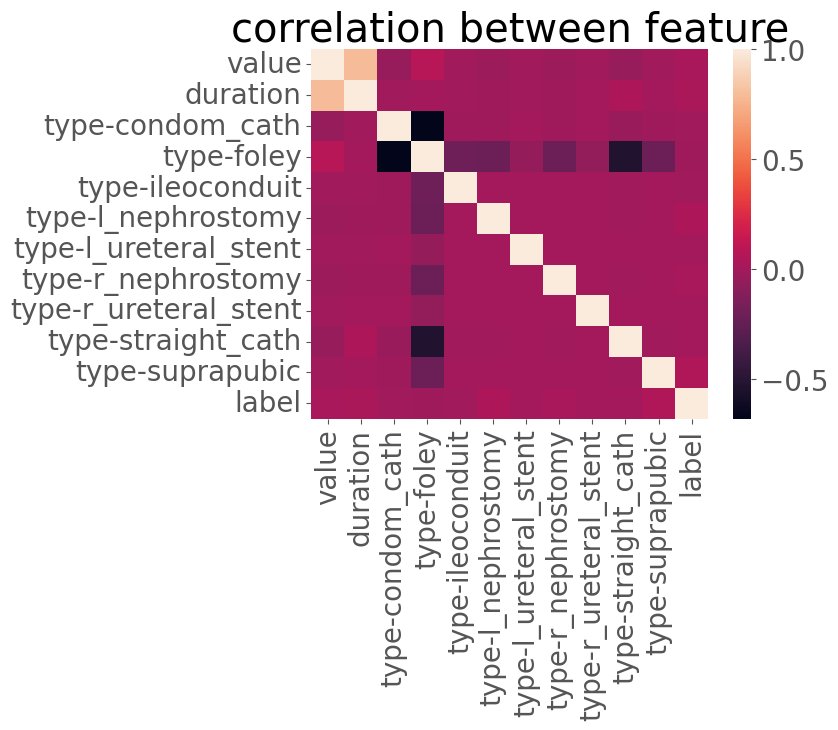

In [131]:
# correlation heatmap
sns.heatmap(cauti_df.corr(), annot=False).set(title="correlation between feature")

In [132]:
# rank correlation to label
cauti_df.corr().loc["label", :].sort_values(ascending=False)

label                    1.000000
type-suprapubic          0.051963
type-l_nephrostomy       0.035319
duration                 0.023451
value                    0.019310
type-r_nephrostomy       0.015569
type-straight_cath       0.006147
type-l_ureteral_stent   -0.001707
type-r_ureteral_stent   -0.002020
type-ileoconduit        -0.006549
type-condom_cath        -0.006750
type-foley              -0.021464
Name: label, dtype: float64

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1248 samples in 0.003s...
[t-SNE] Computed neighbors for 1248 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1248
[t-SNE] Computed conditional probabilities for sample 1248 / 1248
[t-SNE] Mean sigma: 260.918172
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.138008
[t-SNE] KL divergence after 1000 iterations: 0.511361


[Text(0.5, 1.0, 'VAP T-SNE projection')]

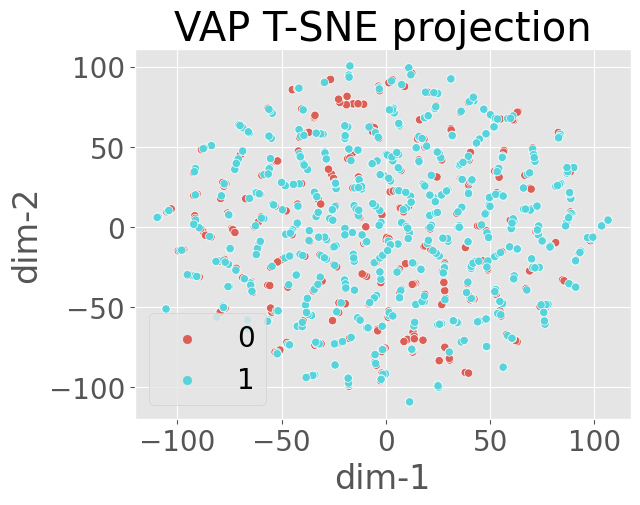

In [134]:
# embedding visualization
sampled = cauti_df.groupby('label', group_keys=False).apply(lambda x: x.sample(cauti_df["label"].sum()))
X = sampled.drop('label',axis = 1)
y = sampled["label"]

tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=2, n_iter=1000)
emb = tsne.fit_transform(X)

df = pd.DataFrame({
    "y": y,
    "dim-1": emb[:, 0],
    "dim-2": emb[:, 1]
})

sns.scatterplot(
    x="dim-1",
    y="dim-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df
).set(title="VAP T-SNE projection")